Raw shape: (168, 2)


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


Using date column: Date
Using value column: Production
Series index range: 1962-01-01 00:00:00 to 1975-12-01 00:00:00
Length: 168


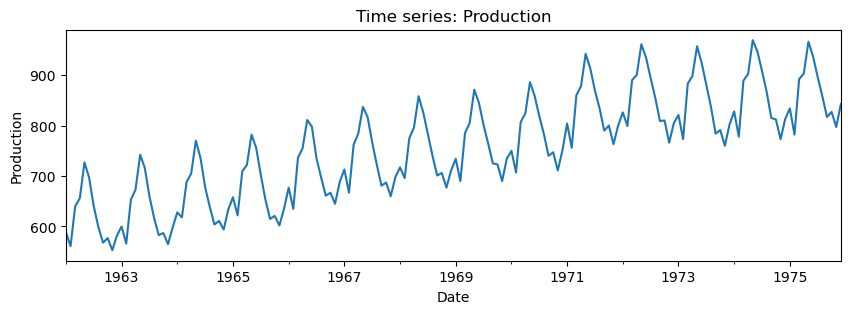

Train length: 156 Test length: 12

Fitting Holt-Winters...
Holt-Winters MAE: 10.7490, RMSE: 11.9324

Fitting SARIMAX (ARIMA) with simple AIC-grid selection...
Selected ARIMA order: (2, 1, 2) AIC: 1563.866867038772
SARIMAX MAE: 57.2703, RMSE: 72.4976

Preparing lag features for RandomForest...
RF train shape: (144, 12) RF test shape: (12, 12)
RandomForest MAE: 13.1813, RMSE: 16.9848

Model comparison (MAE & RMSE):
 - Holt-Winters: MAE=10.7490, RMSE=11.9324
 - SARIMAX: MAE=57.2703, RMSE=72.4976
 - RandomForest: MAE=13.1813, RMSE=16.9848


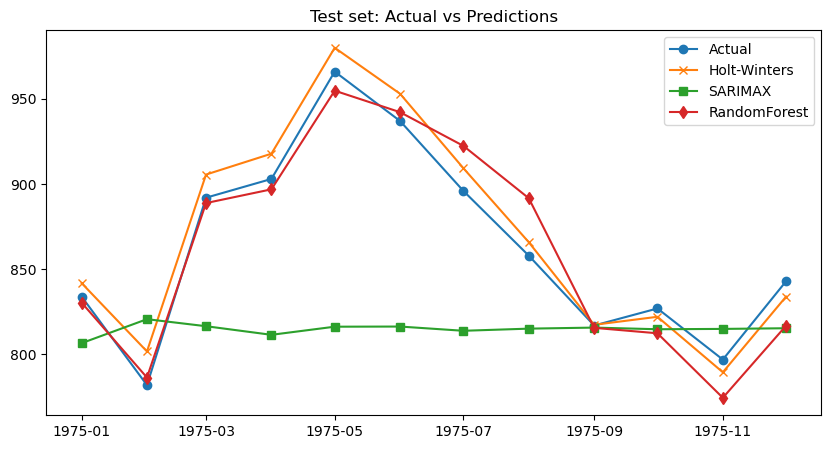


Best model by MAE: Holt-Winters


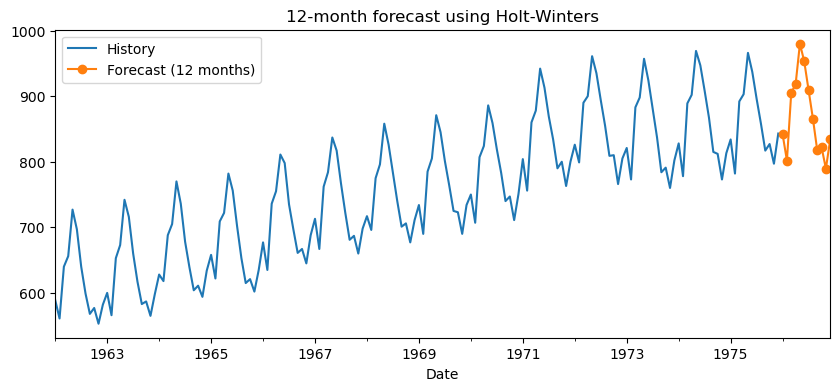


Saved forecast and summary to folder: C:\Users\abhin\milk_forecast_outputs
Done.


In [2]:
# ================= Single-cell: Monthly Milk Forecasting (robust, exact) =================
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# ---------------- CONFIG ----------------
csv_path = r"C:\Users\abhin\Downloads\monthly_milk_production (1).csv"  # <- update if needed
out_dir = Path("milk_forecast_outputs")
out_dir.mkdir(exist_ok=True)

# ---------------- LOAD ----------------
if not Path(csv_path).exists():
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

df_raw = pd.read_csv(csv_path, header=0)
print("Raw shape:", df_raw.shape)
display(df_raw.head())

# ---------------- detect date & value columns ----------------
# heuristics: choose first datetime-like column as date, first numeric other than that as value
date_col = None
for c in df_raw.columns:
    parsed = pd.to_datetime(df_raw[c], errors='coerce')
    if parsed.notna().sum() >= max(1, len(parsed)//2):
        date_col = c
        break
if date_col is None:
    date_col = df_raw.columns[0]

val_col = None
for c in df_raw.columns:
    if c == date_col: continue
    if pd.api.types.is_numeric_dtype(df_raw[c]):
        val_col = c
        break
if val_col is None:
    val_col = df_raw.columns[1] if len(df_raw.columns) > 1 else df_raw.columns[0]

print("Using date column:", date_col)
print("Using value column:", val_col)

# ---------------- build timeseries ----------------
df = df_raw.copy()
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# If index is not a proper datetime index (or has no freq), try to infer and set monthly start frequency
inferred = pd.infer_freq(df.index)
if inferred is None:
    # try to coerce to month period if day is 1 for most rows
    if (df.index.day == 1).sum() / len(df.index) > 0.7:
        df = df.asfreq('MS')  # monthly start
        inferred = 'MS'
else:
    try:
        df = df.asfreq(inferred)
    except Exception:
        pass

series = pd.to_numeric(df[val_col], errors='coerce')

# fill small gaps
series = series.interpolate(method='time').ffill().bfill()

print("Series index range:", series.index.min(), "to", series.index.max())
print("Length:", len(series))
plt.figure(figsize=(10,3)); series.plot(title="Time series: " + str(val_col)); plt.ylabel(val_col); plt.show()

# ---------------- train/test split ----------------
if len(series) > 36:
    test_len = 12
else:
    test_len = max(1, int(len(series) * 0.2))
train_series = series.iloc[:-test_len].dropna()
test_series = series.iloc[-test_len:].dropna()
print("Train length:", len(train_series), "Test length:", len(test_series))

# ---------------- MODEL 1: Holt-Winters ----------------
print("\nFitting Holt-Winters...")
# decide seasonal_periods (monthly -> 12)
seasonal_periods = 12 if (inferred and inferred.upper().startswith('M')) or len(series) > 24 else None
if seasonal_periods:
    hw_model = ExponentialSmoothing(train_series, trend="add", seasonal="add", seasonal_periods=seasonal_periods, initialization_method="estimated")
else:
    hw_model = ExponentialSmoothing(train_series, trend="add", seasonal=None, initialization_method="estimated")
hw_res = hw_model.fit(optimized=True)
hw_forecast = hw_res.forecast(steps=len(test_series))
# align index
hw_forecast.index = test_series.index
hw_pred = hw_forecast
hw_mae = mean_absolute_error(test_series, hw_pred)
hw_rmse = mean_squared_error(test_series, hw_pred, squared=False)
print(f"Holt-Winters MAE: {hw_mae:.4f}, RMSE: {hw_rmse:.4f}")

# ---------------- MODEL 2: SARIMAX (simple grid by AIC) ----------------
print("\nFitting SARIMAX (ARIMA) with simple AIC-grid selection...")
try:
    adf_p = adfuller(train_series.dropna())[1]
    d = 0 if adf_p < 0.05 else 1
except Exception:
    d = 1

best_aic = np.inf
best_order = (1,d,1)
for p in range(0,3):
    for q in range(0,3):
        try:
            mod = SARIMAX(train_series, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
        except Exception:
            continue
print("Selected ARIMA order:", best_order, "AIC:", best_aic)

sarima_mod = SARIMAX(train_series, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_mod.fit(disp=False)
sarima_fore = sarima_res.get_forecast(steps=len(test_series))
sarima_pred = sarima_fore.predicted_mean
# align index
sarima_pred.index = test_series.index
sarima_mae = mean_absolute_error(test_series, sarima_pred)
sarima_rmse = mean_squared_error(test_series, sarima_pred, squared=False)
print(f"SARIMAX MAE: {sarima_mae:.4f}, RMSE: {sarima_rmse:.4f}")

# ---------------- MODEL 3: RandomForest on lag features ----------------
print("\nPreparing lag features for RandomForest...")
def make_lag_df(series, lags=12):
    df_l = pd.DataFrame({'y': series})
    for i in range(1, lags+1):
        df_l[f'lag_{i}'] = df_l['y'].shift(i)
    df_l = df_l.dropna()
    return df_l

lags = 12
df_lag = make_lag_df(series, lags=lags)

# use test_series.index to select test rows from df_lag (ensures alignment)
test_mask = df_lag.index.isin(test_series.index)
train_mask = ~test_mask

# If test_mask yields fewer rows (because shifting), align by selecting last N rows
if test_mask.sum() < len(test_series):
    # fallback: take last len(test_series) rows of df_lag as test
    X = df_lag.drop(columns=['y'])
    y_lag = df_lag['y']
    X_train = X.iloc[:-len(test_series)]
    y_train_lag = y_lag.iloc[:-len(test_series)]
    X_test = X.iloc[-len(test_series):]
    y_test_lag = y_lag.iloc[-len(test_series):]
else:
    X = df_lag.drop(columns=['y'])
    y_lag = df_lag['y']
    X_train = X.loc[train_mask]
    y_train_lag = y_lag.loc[train_mask]
    X_test = X.loc[test_mask].iloc[:len(test_series)]
    y_test_lag = y_lag.loc[test_mask].iloc[:len(test_series)]

print("RF train shape:", X_train.shape, "RF test shape:", X_test.shape)

# scale and fit
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_s, y_train_lag)
rf_pred = rf.predict(X_test_s)
# ensure rf_pred aligns to test_series length
rf_pred = np.array(rf_pred).flatten()[:len(test_series)]
rf_mae = mean_absolute_error(test_series.iloc[:len(rf_pred)], rf_pred)
rf_rmse = mean_squared_error(test_series.iloc[:len(rf_pred)], rf_pred, squared=False)
print(f"RandomForest MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}")

# ---------------- Compare models ----------------
scores = {
    "Holt-Winters": {"mae": hw_mae, "rmse": hw_rmse},
    "SARIMAX": {"mae": sarima_mae, "rmse": sarima_rmse},
    "RandomForest": {"mae": rf_mae, "rmse": rf_rmse}
}
print("\nModel comparison (MAE & RMSE):")
for k,v in scores.items():
    print(f" - {k}: MAE={v['mae']:.4f}, RMSE={v['rmse']:.4f}")

# ---------------- Plot predictions vs actual ----------------
plt.figure(figsize=(10,5))
test_index = test_series.index
plt.plot(test_index, test_series.values, label='Actual', marker='o')
plt.plot(test_index, hw_pred.values, label='Holt-Winters', marker='x')
plt.plot(test_index, sarima_pred.values, label='SARIMAX', marker='s')
# RF may have shorter length; align accordingly
rf_index = test_index[:len(rf_pred)]
plt.plot(rf_index, rf_pred, label='RandomForest', marker='d')
plt.legend(); plt.title("Test set: Actual vs Predictions"); plt.show()

# ---------------- Choose best model by MAE and forecast next 12 months ----------------
best_model_name = min(scores.keys(), key=lambda k: scores[k]['mae'])
print("\nBest model by MAE:", best_model_name)
n_forecast = 12

if best_model_name == "Holt-Winters":
    forecast_vals = hw_res.forecast(steps=n_forecast)
    forecast_index = pd.date_range(start=series.index.max() + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS' if inferred is None else inferred)
    forecast_series = pd.Series(forecast_vals.values, index=forecast_index)
elif best_model_name == "SARIMAX":
    forecast_res = sarima_res.get_forecast(steps=n_forecast)
    forecast_vals = forecast_res.predicted_mean
    forecast_index = pd.date_range(start=series.index.max() + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS' if inferred is None else inferred)
    forecast_series = pd.Series(forecast_vals.values, index=forecast_index)
else:
    last_window = series.dropna().values[-lags:].tolist()
    rf_forecast = []
    curr = last_window.copy()
    for i in range(n_forecast):
        x_in = np.array(curr[-lags:])[::-1].reshape(1,-1)
        x_in_s = scaler.transform(x_in)
        pred = rf.predict(x_in_s)[0]
        rf_forecast.append(pred)
        curr.append(pred)
    forecast_index = pd.date_range(start=series.index.max() + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS' if inferred is None else inferred)
    forecast_series = pd.Series(rf_forecast, index=forecast_index)

# ---------------- Plot forecast ----------------
plt.figure(figsize=(10,4))
series.plot(label='History')
forecast_series.plot(label='Forecast (12 months)', marker='o')
plt.legend(); plt.title(f"12-month forecast using {best_model_name}"); plt.show()

# ---------------- Save outputs ----------------
forecast_df = forecast_series.reset_index()
forecast_df.columns = ['date','forecast']
forecast_csv = out_dir / "milk_12month_forecast_classical.csv"
forecast_df.to_csv(forecast_csv, index=False)

summary = {
    "selected_arima_order": best_order,
    "scores": scores,
    "best_model": best_model_name,
    "forecast_csv": str(forecast_csv.resolve())
}
with open(out_dir / "models_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved forecast and summary to folder:", out_dir.resolve())
print("Done.")
